
# Slooze — Inventory, Purchase, Sales Analysis and Optimization

This notebook walks through a step-by-step analysis of Slooze’s sales, purchase, and inventory data. The goal is to make the workflow easy, while still introducing important concepts in inventory management and demand forecasting.

We will cover:

1. Data Loading & Cleaning – importing and preparing the datasets.

2. Exploratory Data Analysis (EDA) – understanding sales trends, purchases, and stock movement.

3. Inventory Analysis – identifying stock levels, fast- vs slow-moving items, and overall performance.

4. ABC Classification – ranking products by importance (high-value vs low-value).

5. EOQ & ROP Calculations – learning how to decide when and how much to reorder.

6. Forecasting – using a simple moving average to estimate future demand.

7. Insights & Recommendations – summarizing what we found and how it can help in decision-making.

In [1]:

# === Simple imports & configuration ===
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# Output folder
OUT_DIR = Path("./outputs")
OUT_DIR.mkdir(exist_ok=True)

# File names (place CSVs beside this notebook)
FILES = {
    "sales": Path("SalesFINAL12312016.csv"),
    "endinv": Path("EndInvFINAL12312016.csv"),
    "inv_purch": Path("InvoicePurchases12312016.csv"),
    "purchases": Path("PurchasesFINAL12312016.csv"),
    "beginv": Path("BegInvFINAL12312016.csv"),
    "purchase_prices": Path("2017PurchasePricesDec.csv")
}

# Business defaults (easy to change)
ORDERING_COST_PER_PO = 500.0   # K
HOLDING_RATE = 0.20            # fraction per year
SERVICE_LEVEL = 0.95
Z_TABLE = {0.90:1.28, 0.95:1.65, 0.98:2.05, 0.99:2.33}
Z = Z_TABLE.get(SERVICE_LEVEL, 1.65)
print('Ready.')


Ready.


## 1. Load files (safe & friendly)

In [2]:

def read_csv_safe(p):
    if not p.exists():
        print(f" - NOTE: {p.name} not found. Skipping.")
        return None
    try:
        df = pd.read_csv(p, low_memory=False)
        print(f" - Loaded {p.name} with shape {df.shape}")
        return df
    except Exception as e:
        print(f" - Could not read {p.name}: {e}")
        return None

sales = read_csv_safe(FILES['sales'])
endinv = read_csv_safe(FILES['endinv'])
inv_purch = read_csv_safe(FILES['inv_purch'])
purchases = read_csv_safe(FILES['purchases'])
beginv = read_csv_safe(FILES['beginv'])
purchase_prices = read_csv_safe(FILES['purchase_prices'])

print('\nFiles loaded status:')
for k in FILES:
    print(' -', k, '->', 'present' if locals()[k] is not None else 'missing')


 - Loaded SalesFINAL12312016.csv with shape (1048575, 14)
 - Loaded EndInvFINAL12312016.csv with shape (224489, 9)
 - Loaded InvoicePurchases12312016.csv with shape (5543, 10)
 - Loaded PurchasesFINAL12312016.csv with shape (2372474, 16)
 - Loaded BegInvFINAL12312016.csv with shape (206529, 9)
 - Loaded 2017PurchasePricesDec.csv with shape (12261, 9)

Files loaded status:
 - sales -> present
 - endinv -> present
 - inv_purch -> present
 - purchases -> present
 - beginv -> present
 - purchase_prices -> present


## 2. Simple cleaning & standardization

In [3]:

def standardize(df):
    if df is None: return None
    df = df.copy()
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(r'[^0-9a-zA-Z_]', '', regex=True)
    for c in df.select_dtypes(include=['object']).columns:
        df[c] = df[c].astype(str).str.strip()
    for c in df.columns:
        if 'date' in c:
            try:
                df[c] = pd.to_datetime(df[c], errors='coerce')
            except Exception:
                pass
    return df

sales = standardize(sales)
endinv = standardize(endinv)
inv_purch = standardize(inv_purch)
purchases = standardize(purchases)
beginv = standardize(beginv)
purchase_prices = standardize(purchase_prices)

print('Standardized column names for present datasets.')


Standardized column names for present datasets.


## 3. Quick EDA — peek and summary

In [4]:

def peek(df, name):
    if df is None:
        print(f"{name}: MISSING\n")
        return
    print(f"{name} — shape: {df.shape}\nColumns: {list(df.columns)[:10]}\nNulls:\n{df.isnull().sum().head(10)}\n")
    display(df.head(3))

peek(sales, 'Sales')
peek(endinv, 'End Inventory')
peek(inv_purch, 'Invoice Purchases')
peek(purchases, 'Purchases (optional)')
peek(beginv, 'Begin Inventory (optional)')
peek(purchase_prices, 'Purchase Prices (optional)')


Sales — shape: (1048575, 14)
Columns: ['inventoryid', 'store', 'brand', 'description', 'size', 'salesquantity', 'salesdollars', 'salesprice', 'salesdate', 'volume']
Nulls:
inventoryid      0
store            0
brand            0
description      0
size             0
salesquantity    0
salesdollars     0
salesprice       0
salesdate        0
volume           0
dtype: int64



,inventoryid,store,brand,description,size,salesquantity,salesdollars,salesprice,salesdate,volume,classification,excisetax,vendorno,vendorname
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2016-01-01,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,2016-01-02,750,1,1.57,12546,JIM BEAM BRANDS COMPANY
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2016-01-03,750,1,0.79,12546,JIM BEAM BRANDS COMPANY


End Inventory — shape: (224489, 9)
Columns: ['inventoryid', 'store', 'city', 'brand', 'description', 'size', 'onhand', 'price', 'enddate']
Nulls:
inventoryid    0
store          0
city           0
brand          0
description    0
size           0
onhand         0
price          0
enddate        0
dtype: int64



,inventoryid,store,city,brand,description,size,onhand,price,enddate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,11,12.99,2016-12-31
1,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,7,36.99,2016-12-31
2,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,7,38.99,2016-12-31


Invoice Purchases — shape: (5543, 10)
Columns: ['vendornumber', 'vendorname', 'invoicedate', 'ponumber', 'podate', 'paydate', 'quantity', 'dollars', 'freight', 'approval']
Nulls:
vendornumber    0
vendorname      0
invoicedate     0
ponumber        0
podate          0
paydate         0
quantity        0
dollars         0
freight         0
approval        0
dtype: int64



,vendornumber,vendorname,invoicedate,ponumber,podate,paydate,quantity,dollars,freight,approval
0,105,ALTAMAR BRANDS LLC,2016-01-04,8124,2015-12-21,2016-02-16,6,214.26,3.47,None
1,4466,AMERICAN VINTAGE BEVERAGE,2016-01-07,8137,2015-12-22,2016-02-21,15,140.55,8.57,None
2,388,ATLANTIC IMPORTING COMPANY,2016-01-09,8169,2015-12-24,2016-02-16,5,106.60,4.61,None


Purchases (optional) — shape: (2372474, 16)
Columns: ['inventoryid', 'store', 'brand', 'description', 'size', 'vendornumber', 'vendorname', 'ponumber', 'podate', 'receivingdate']
Nulls:
inventoryid      0
store            0
brand            0
description      0
size             0
vendornumber     0
vendorname       0
ponumber         0
podate           0
receivingdate    0
dtype: int64



,inventoryid,store,brand,description,size,vendornumber,vendorname,ponumber,podate,receivingdate,invoicedate,paydate,purchaseprice,quantity,dollars,classification
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2015-12-21,2016-01-02,2016-01-04,2016-02-16,35.71,6,214.26,1
1,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,4,37.40,1
2,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-02,2016-01-07,2016-02-21,9.41,5,47.05,1


Begin Inventory (optional) — shape: (206529, 9)
Columns: ['inventoryid', 'store', 'city', 'brand', 'description', 'size', 'onhand', 'price', 'startdate']
Nulls:
inventoryid    0
store          0
city           0
brand          0
description    0
size           0
onhand         0
price          0
startdate      0
dtype: int64



,inventoryid,store,city,brand,description,size,onhand,price,startdate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,8,12.99,2016-01-01
1,1_HARDERSFIELD_60,1,HARDERSFIELD,60,Canadian Club 1858 VAP,750mL,7,10.99,2016-01-01
2,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,6,36.99,2016-01-01


Purchase Prices (optional) — shape: (12261, 9)
Columns: ['brand', 'description', 'price', 'size', 'volume', 'classification', 'purchaseprice', 'vendornumber', 'vendorname']
Nulls:
brand             0
description       0
price             0
size              0
volume            0
classification    0
purchaseprice     0
vendornumber      0
vendorname        0
dtype: int64



,brand,description,price,size,volume,classification,purchaseprice,vendornumber,vendorname
0,58,Gekkeikan Black & Gold Sake,12.99,750mL,750,1,9.28,8320,SHAW ROSS INT L IMP LTD
1,62,Herradura Silver Tequila,36.99,750mL,750,1,28.67,1128,BROWN-FORMAN CORP
2,63,Herradura Reposado Tequila,38.99,750mL,750,1,30.46,1128,BROWN-FORMAN CORP


## 4. Sales aggregation — daily & weekly totals

In [5]:

if sales is not None and 'salesdate' in sales.columns:
    sales['salesdate'] = pd.to_datetime(sales['salesdate'], errors='coerce')
    if 'salesquantity' in sales.columns:
        sales['salesquantity'] = pd.to_numeric(sales['salesquantity'], errors='coerce').fillna(0)
    if 'salesdollars' in sales.columns:
        sales['salesdollars'] = pd.to_numeric(sales['salesdollars'], errors='coerce').fillna(0)
    daily = sales.groupby(['inventoryid','salesdate'], dropna=False).agg(units=('salesquantity','sum'), sales_value=('salesdollars','sum')).reset_index()
    weekly = daily.set_index('salesdate').groupby('inventoryid').resample('W').sum().reset_index()
    sku_totals = sales.groupby('inventoryid', dropna=False).agg(units=('salesquantity','sum'), sales_value=('salesdollars','sum')).reset_index().sort_values('sales_value', ascending=False)
    print('Aggregations ready. SKUs found:', sku_totals.shape[0])
else:
    print('Sales data not available or missing salesdate.')
    daily = None; weekly = None; sku_totals = None


Aggregations ready. SKUs found: 170131


## 5. Visualizations — top SKUs and trends (matplotlib)

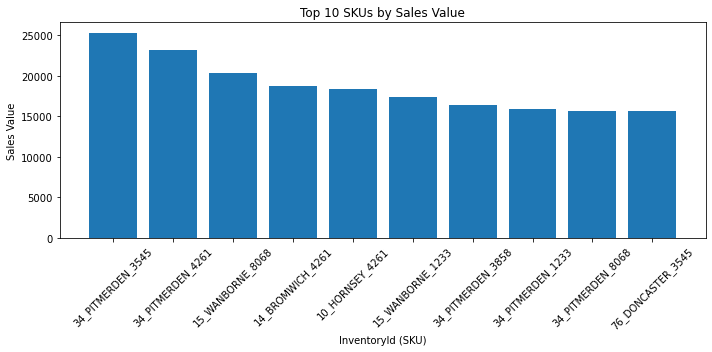

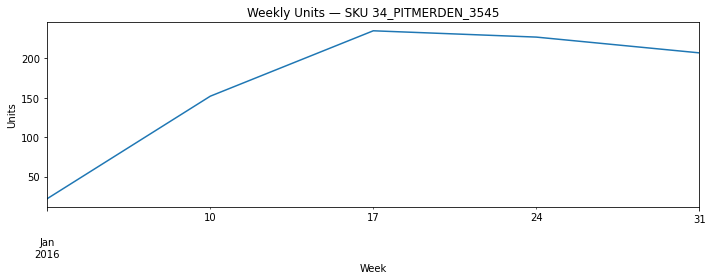

In [6]:

# 5.1 Top SKUs by sales
if sku_totals is not None and not sku_totals.empty:
    top_n = 10
    top = sku_totals.head(top_n)
    plt.figure(figsize=(10,5))
    plt.bar(top['inventoryid'].astype(str), top['sales_value'])
    plt.title(f'Top {top_n} SKUs by Sales Value')
    plt.xlabel('InventoryId (SKU)')
    plt.ylabel('Sales Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('Top SKUs plot skipped.')

# 5.2 Weekly trend for top SKU
if weekly is not None and not weekly.empty:
    top_sku = sku_totals.iloc[0]['inventoryid']
    sku_weekly = weekly[weekly['inventoryid']==top_sku].set_index('salesdate')['units'].resample('W').sum()
    plt.figure(figsize=(10,4))
    sku_weekly.plot()
    plt.title(f'Weekly Units — SKU {top_sku}')
    plt.xlabel('Week')
    plt.ylabel('Units')
    plt.tight_layout()
    plt.show()
else:
    print('Weekly trend skipped.')


## 6. ABC classification (simple)

,inventoryid,units,sales_value,cum_share,abc
0,34_PITMERDEN_3545,843,25325.57,0.000764,A
1,34_PITMERDEN_4261,1055,23199.45,0.001464,A
2,15_WANBORNE_8068,810,20406.90,0.002080,A
3,14_BROMWICH_4261,850,18691.50,0.002644,A
4,10_HORNSEY_4261,836,18400.64,0.003199,A
5,15_WANBORNE_1233,483,17383.17,0.003724,A
6,34_PITMERDEN_3858,685,16433.15,0.004220,A
7,34_PITMERDEN_1233,441,15871.59,0.004699,A
8,34_PITMERDEN_8068,606,15725.94,0.005173,A
9,76_DONCASTER_3545,521,15670.79,0.005646,A


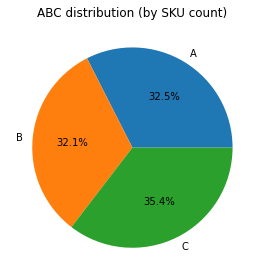

In [7]:

def abc_classify(df, a_cut=0.80, b_cut=0.95):
    df = df.copy()
    df['sales_value'] = df['sales_value'].fillna(0)
    df = df.sort_values('sales_value', ascending=False).reset_index(drop=True)
    df['cum_share'] = df['sales_value'].cumsum() / (df['sales_value'].sum() if df['sales_value'].sum()!=0 else 1)
    def cls(x):
        if x <= a_cut: return 'A'
        if x <= b_cut: return 'B'
        return 'C'
    df['abc'] = df['cum_share'].apply(cls)
    return df

if sku_totals is not None:
    abc_df = abc_classify(sku_totals)
    display(abc_df.head(15))
    # small pie for ABC distribution by count
    counts = abc_df['abc'].value_counts().reindex(['A','B','C']).fillna(0)
    plt.figure(figsize=(6,4))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
    plt.title('ABC distribution (by SKU count)')
    plt.tight_layout()
    plt.show()
    abc_df.to_csv(OUT_DIR / 'abc_simple.csv', index=False)
else:
    print('ABC skipped.')


## 7. EOQ & Reorder Point (simple formulas)

In [8]:

import math

def compute_eoq(D, K=ORDERING_COST_PER_PO, h=1.0):
    if D <= 0 or h <= 0 or math.isnan(D) or math.isnan(h):
        return np.nan
    return math.sqrt((2.0 * D * K) / h)

# get unit cost information
unit_cost = None
if purchases is not None and 'inventoryid' in purchases.columns:
    if 'unitcost' in purchases.columns:
        unit_cost = purchases.groupby('inventoryid')['unitcost'].median().reset_index().rename(columns={'unitcost':'unit_cost'})
    elif set(['extendedcost','quantity']).issubset(purchases.columns):
        tmp = purchases.copy()
        tmp['unit_cost_calc'] = tmp['extendedcost'] / tmp['quantity'].replace(0,np.nan)
        unit_cost = tmp.groupby('inventoryid')['unit_cost_calc'].median().reset_index().rename(columns={'unit_cost_calc':'unit_cost'})

if unit_cost is None and purchase_prices is not None and set(['inventoryid','price']).issubset(purchase_prices.columns):
    unit_cost = purchase_prices.groupby('inventoryid')['price'].median().reset_index().rename(columns={'price':'unit_cost'})

if unit_cost is None and endinv is not None and 'price' in endinv.columns:
    unit_cost = endinv.groupby('inventoryid')['price'].median().reset_index().rename(columns={'price':'unit_cost'})

if unit_cost is None and sales is not None and 'salesprice' in sales.columns:
    unit_cost = sales.groupby('inventoryid')['salesprice'].median().reset_index().rename(columns={'salesprice':'unit_cost'})
    unit_cost['unit_cost'] = unit_cost['unit_cost']*0.7  # assume cost is lower than price

print('Unit cost rows:', 0 if unit_cost is None else unit_cost.shape[0])

# Build simple EOQ table
if sku_totals is not None:
    eoq_table = sku_totals[['inventoryid','units','sales_value']].copy().rename(columns={'units':'annual_units'})
    if unit_cost is not None:
        eoq_table = eoq_table.merge(unit_cost, on='inventoryid', how='left')
    else:
        eoq_table['unit_cost'] = np.nan
    eoq_table['unit_cost'] = eoq_table['unit_cost'].fillna(eoq_table['sales_value'] / eoq_table['annual_units'].replace(0,np.nan)).fillna(1.0)
    eoq_table['holding_cost'] = eoq_table['unit_cost'] * HOLDING_RATE
    eoq_table['eoq'] = eoq_table.apply(lambda r: compute_eoq(r['annual_units'], ORDERING_COST_PER_PO, r['holding_cost']), axis=1)
    eoq_table['daily_mean'] = eoq_table['annual_units'] / 365.0
    eoq_table['daily_std'] = np.sqrt(eoq_table['daily_mean'].clip(lower=0))
    eoq_table['lead_time_days'] = 7.0
    eoq_table['rop'] = eoq_table['daily_mean'] * eoq_table['lead_time_days'] + Z * eoq_table['daily_std'] * np.sqrt(eoq_table['lead_time_days'])
    # on-hand merge from endinv or beginv
    if endinv is not None and set(['inventoryid','onhand']).issubset(endinv.columns):
        onhand = endinv.groupby('inventoryid')['onhand'].sum().reset_index()
        eoq_table = eoq_table.merge(onhand, on='inventoryid', how='left')
    elif beginv is not None and set(['inventoryid','onhand']).issubset(beginv.columns):
        onhand = beginv.groupby('inventoryid')['onhand'].sum().reset_index()
        eoq_table = eoq_table.merge(onhand, on='inventoryid', how='left')
    else:
        eoq_table['onhand'] = np.nan
    # recommended order qty
    def rec_order(r):
        if pd.isna(r['onhand']) or pd.isna(r['rop']) or pd.isna(r['eoq']):
            return np.nan
        if r['onhand'] <= r['rop']:
            return max(r['eoq'], r['rop'] + r['eoq'] - r['onhand'])
        return 0.0
    eoq_table['recommended_order_qty'] = eoq_table.apply(rec_order, axis=1)
    display(eoq_table.head(10))
    eoq_table.to_csv(OUT_DIR / 'eoq_rop_simple.csv', index=False)
else:
    print('EOQ table skipped because sku_totals missing.')


Unit cost rows: 224489


,inventoryid,annual_units,sales_value,unit_cost,holding_cost,eoq,daily_mean,daily_std,lead_time_days,rop,onhand,recommended_order_qty
0,34_PITMERDEN_3545,843,25325.57,29.99,5.998,374.895784,2.309589,1.519733,7.0,22.801503,853.0,0.0
1,34_PITMERDEN_4261,1055,23199.45,20.99,4.198,501.308436,2.890411,1.700121,7.0,27.654737,612.0,0.0
2,15_WANBORNE_8068,810,20406.90,23.49,4.698,415.227399,2.219178,1.489691,7.0,22.037475,199.0,0.0
3,14_BROMWICH_4261,850,18691.50,20.99,4.198,449.974855,2.328767,1.526030,7.0,22.963237,71.0,0.0
4,10_HORNSEY_4261,836,18400.64,20.99,4.198,446.253794,2.290411,1.513410,7.0,22.639654,223.0,0.0
5,15_WANBORNE_1233,483,17383.17,34.99,6.998,262.716044,1.323288,1.150342,7.0,14.284822,335.0,0.0
6,34_PITMERDEN_3858,685,16433.15,23.99,4.798,377.846291,1.876712,1.369932,7.0,19.117408,88.0,0.0
7,34_PITMERDEN_1233,441,15871.59,34.99,6.998,251.033873,1.208219,1.099190,7.0,13.256038,501.0,0.0
8,34_PITMERDEN_8068,606,15725.94,23.49,4.698,359.153254,1.660274,1.288516,7.0,17.246922,573.0,0.0
9,76_DONCASTER_3545,521,15670.79,29.99,5.998,294.724087,1.427397,1.194737,7.0,15.207394,692.0,0.0


## 8. Simple lead time (if PO & Invoice dates exist)

In [9]:

if inv_purch is not None:
    if 'podate' in inv_purch.columns and 'invoicedate' in inv_purch.columns:
        inv_purch['lead_time_days'] = (pd.to_datetime(inv_purch['invoicedate']) - pd.to_datetime(inv_purch['podate'])).dt.days
        vendor_lt = inv_purch.groupby(['vendornumber','vendorname'], dropna=False)['lead_time_days'].agg(['count','mean','median','std','min','max']).reset_index().rename(columns={'mean':'lt_mean'})
        display(vendor_lt.head(10))
        vendor_lt.to_csv(OUT_DIR / 'vendor_lead_times_simple.csv', index=False)
    else:
        print('inv_purch present but missing podate or invoicedate columns.')
else:
    print('inv_purch missing, skipping vendor lead time analysis.')


,vendornumber,vendorname,count,lt_mean,median,std,min,max
0,2,"IRA GOLDMAN AND WILLIAMS, LLP",4,16.500000,16.5,3.109126,13,20
1,54,AAPER ALCOHOL & CHEMICAL CO,1,14.000000,14.0,NaN,14,14
2,60,ADAMBA IMPORTS INTL INC,35,16.485714,17.0,2.893923,11,22
3,105,ALTAMAR BRANDS LLC,40,16.975000,16.5,3.254090,10,23
4,200,AMERICAN SPIRITS EXCHANGE,6,18.833333,19.5,2.786874,15,22
5,287,APPOLO VINEYARDS LLC,13,16.384615,17.0,3.176436,11,21
6,388,ATLANTIC IMPORTING COMPANY,53,16.509434,16.0,3.790792,10,23
7,480,BACARDI USA INC,55,17.181818,17.0,3.328279,10,23
8,516,BANFI PRODUCTS CORP,55,16.454545,16.0,3.184559,10,22
9,653,STATE WINE & SPIRITS,55,16.163636,16.0,3.298505,9,23


## 9. Simple forecasting (4-week moving average)

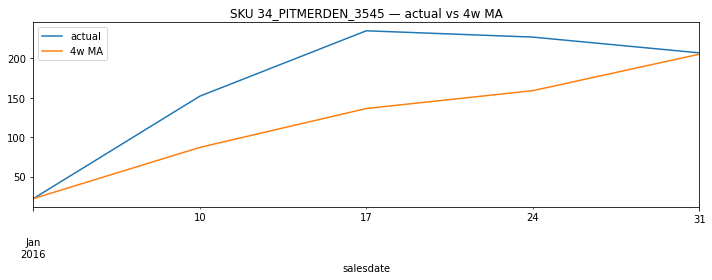

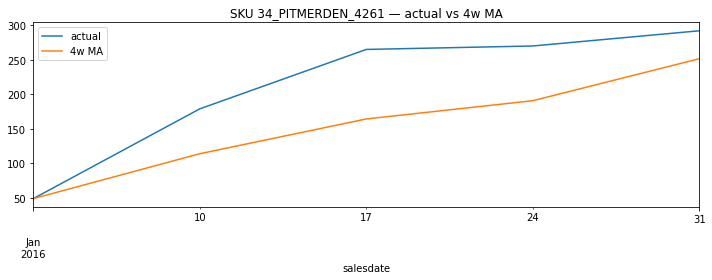

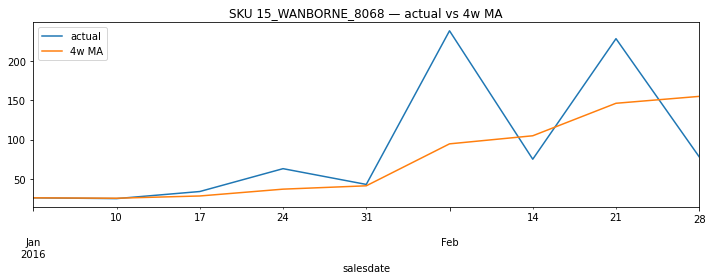

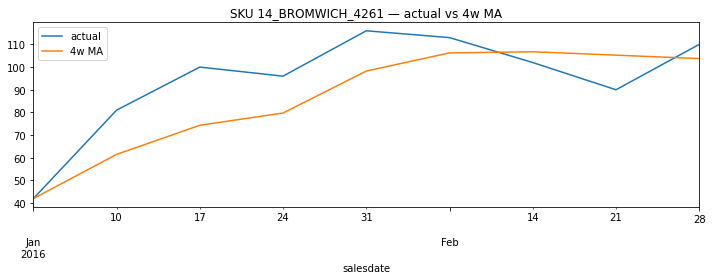

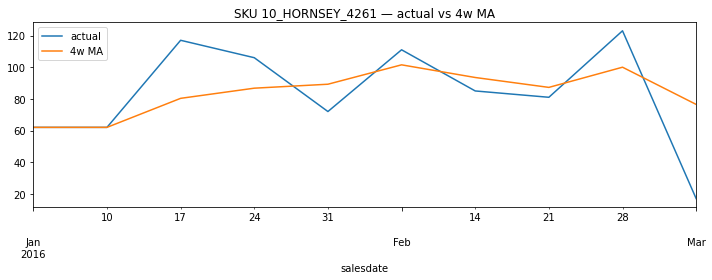

,inventoryid,week,forecast_units
0,34_PITMERDEN_3545,2016-02-07,205.25
1,34_PITMERDEN_3545,2016-02-14,205.25
2,34_PITMERDEN_3545,2016-02-21,205.25
3,34_PITMERDEN_3545,2016-02-28,205.25
4,34_PITMERDEN_3545,2016-03-06,205.25
5,34_PITMERDEN_3545,2016-03-13,205.25
6,34_PITMERDEN_3545,2016-03-20,205.25
7,34_PITMERDEN_3545,2016-03-27,205.25
8,34_PITMERDEN_4261,2016-02-07,251.50
9,34_PITMERDEN_4261,2016-02-14,251.50


In [10]:

FORECAST_WEEKS = 8
if weekly is not None and not weekly.empty:
    top_n = min(5, len(sku_totals))
    forecasts = []
    for sku in sku_totals.head(top_n)['inventoryid']:
        s = weekly[weekly['inventoryid']==sku].set_index('salesdate')['units'].resample('W').sum().fillna(0)
        s_ma4 = s.rolling(4, min_periods=1).mean()
        last_ma = s_ma4.dropna().iloc[-1] if len(s_ma4.dropna())>0 else s.mean()
        last_week = s.index.max()
        future_weeks = [last_week + timedelta(weeks=i) for i in range(1, FORECAST_WEEKS+1)]
        fvals = [last_ma] * FORECAST_WEEKS
        df_fc = pd.DataFrame({'inventoryid': sku, 'week': future_weeks, 'forecast_units': fvals})
        forecasts.append(df_fc)
        plt.figure(figsize=(10,4))
        s.plot(label='actual')
        s_ma4.plot(label='4w MA')
        plt.title(f'SKU {sku} — actual vs 4w MA')
        plt.legend()
        plt.tight_layout()
        plt.show()
    forecasts_df = pd.concat(forecasts, ignore_index=True)
    forecasts_df.to_csv(OUT_DIR / 'forecasts_simple_ma4.csv', index=False)
    display(forecasts_df.head(10))
else:
    print('Forecasting skipped — weekly series missing.')


## 10. Save a short EDA summary and final notes

In [11]:

with open(OUT_DIR / 'eda_quick_summary.txt', 'w', encoding='utf-8') as f:
    f.write('Slooze — Quick EDA Summary\n\n')
    if sku_totals is not None:
        f.write('Top 10 SKUs by sales:\n')
        f.write(sku_totals.head(10).to_string(index=False))
        f.write('\n\n')
    if 'abc_df' in globals():
        f.write('ABC counts:\n' + str(abc_df['abc'].value_counts().to_dict()) + '\n\n')
    if 'eoq_table' in globals():
        f.write('EOQ sample:\n' + eoq_table.head(10).to_string(index=False) + '\n\n')
print('Saved summary and CSV outputs to outputs/ folder.')


Saved summary and CSV outputs to outputs/ folder.


# Conclusion

In this project, we explored Slooze’s sales, purchase, and inventory data step by step. We started with data cleaning and exploration, then moved on to inventory analysis. Along the way, we calculated demand, applied the ABC classification to identify important SKUs, estimated EOQ (Economic Order Quantity) and ROP (Reorder Point), and created simple forecasts using a moving average.

From the analysis, we learned:

- Top SKUs account for most of the sales and should be managed more carefully.

- Demand patterns vary across products, and some show seasonal or irregular trends.

- ABC analysis helps focus on high-value items (A-class) rather than spreading effort equally across all SKUs.

- EOQ and ROP give useful guidelines for when and how much to reorder, reducing both stockouts and excess inventory.

- Forecasting with moving averages provides a quick way to estimate future demand, though more advanced models could improve accuracy.

Overall, this beginner-friendly workflow shows how data analysis and simple inventory models can support better decision-making in supply chain management. Even with basic tools, businesses can identify key products, balance inventory costs, and plan ahead more effectively.